In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, f1_score, classification_report, matthews_corrcoef, recall_score
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import sys

import json
from pprint import pprint

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, accuracy_score


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional
from tensorflow.keras.models import load_model

import json
import pandas as pd

!pip install neurodsp

from neurodsp.burst import detect_bursts_dual_threshold



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 2.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Get the current working directory (where your notebook is)
current_directory = os.getcwd()


# Construct the full path to your data_utils.py file
data_utils_path = '/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Thesis Files/data_utils.py'  # Replace with the actual path

# Add the directory containing data_utils.py to the Python path
sys.path.append(os.path.dirname(data_utils_path))  # Add parent directory of data_utils.py
# Now you can import the custom module
import data_utils as du
import analysis_utils as au

sys.path = current_directory
print(sys.path)

Mounted at /content/drive
/content


In [3]:
basePath = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/Model Comparisons/"

# Comparisons


### Helper Functions

In [4]:
def format_model_results(results):
    """
    Formats model results from a dictionary into a Pandas DataFrame.

    Args:
        results (dict): A dictionary containing model results.

    Returns:
        pd.DataFrame: A formatted DataFrame with model metrics.
    """

    metrics = ["Accuracy", "MCC", "Train Time (s)", "Inference Time (ms)", "Parameters"]
    table_data = {}

    for model, model_data in results.items():
        table_data[model] = {}
        for metric in metrics:
            if metric in ["Accuracy", "MCC"]:
                table_data[model][metric] = f"{model_data[metric]['mean']:.4f} ± {model_data[metric]['std']:.4f}"
            elif metric == "Train Time (s)":
                table_data[model][metric] = f"{model_data[metric]['mean']:.2f} ± {model_data[metric]['std']:.2f}"  # Include standard deviation
            elif metric == "Inference Time (ms)":
                inference_time_s_sample_mean = model_data["Inference Time (s/sample)"].get('mean', model_data["Inference Time (s/sample)"])
                inference_time_s_sample_std = model_data["Inference Time (s/sample)"].get('std', 0)  # Default to 0 if 'std' is not present

                inference_time_ms_mean = inference_time_s_sample_mean * 1000
                inference_time_ms_std = inference_time_s_sample_std * 1000  # Convert std to ms

                table_data[model][metric] = f"{inference_time_ms_mean:.2f} ± {inference_time_ms_std:.2f}"  # Include standard deviation
            elif metric == "Parameters":
                if model_data[metric] == "N/A":
                    table_data[model][metric] = model_data[metric]
                else:
                    table_data[model][metric] = int(model_data[metric])

    df = pd.DataFrame.from_dict(table_data, orient="index")
    df.columns = metrics
    return df

def plot_training_history(results, metric="Validation Accuracy"):
    """
    Plots the training history for a given metric with mean and standard deviation.
    """
    plt.figure(figsize=(10, 6))

    for model, model_data in results.items():
        history = np.array(model_data[metric])  # Shape: (folds, epochs)
        mean_values = np.mean(history, axis=0)
        std_values = np.std(history, axis=0)

        epochs = np.arange(len(mean_values))
        plt.plot(epochs, mean_values, label=model)
        plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2)
    print("Num Epochs", epochs)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"{metric} Across Models")
    plt.legend()
    plt.grid(True)
    # plt.show()


def plot_model_comparison(all_dfs, df_names, metric="MCC", fixed_y=False):
    """
    Plots model comparison for multiple dataframes with Seaborn colors and Matplotlib error bars.

    Args:
        all_dfs (list): A list of Pandas DataFrames containing model results.
        df_names (list): A list of names corresponding to the DataFrames in all_dfs.
        metric (str): The metric to compare (e.g., "MCC", "Accuracy", "Train Time (s)", etc.).
                      Defaults to "MCC".
    """

    num_plots = len(all_dfs)
    num_cols = 2  # Number of columns in the subplot grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 16))
    axes = axes.flatten()  # Flatten the axes array

    # Get Seaborn color palette
    colors = sns.color_palette("viridis", n_colors=len(all_dfs[0])) # Get colors for the first dataframe

    for i, df in enumerate(all_dfs):
        ax = axes[i]

        # Bar positions
        index = np.arange(len(df.index))

        # Special case for "Parameters" metric
        if metric == "Parameters":
            metric_data = df[metric].astype(float)  # Convert to numeric if needed
            ax.bar(index, metric_data, color=colors)  # Plot without error bars
            ax.set_ylim(0,max(metric_data)*1.1)
        else:
            metric_data = df[metric].str.split(" ± ", expand=True).astype(float)
            ax.bar(index, metric_data[0], yerr=metric_data[1], capsize=8, color=colors)
            if fixed_y:
                ax.set_ylim(0,1)
            else:
                # Max adjusted y-axis limits
                ax.set_ylim(min(metric_data[0] - metric_data[1])-0.2*abs(min(metric_data[0] - metric_data[1])),max(metric_data[0] + metric_data[1])*1.1)  # Assuming all metrics are in range 0-1


        ax.set_title(f"Model Comparison - {df_names[i]}")
        ax.set_ylabel(metric)
        ax.set_xticks(index)
        ax.set_xticklabels(df.index, rotation=45, ha='right', va='top')



    # Hide any extra subplots if num_plots is not a multiple of num_cols
    for j in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def create_heatmap_from_dfs(all_dfs, df_names, metric="MCC", rounding_factor=3, rows_to_remove=[]):
    """
    Creates a heatmap from multiple DataFrames using a specified metric.

    Args:
        all_dfs (list): A list of Pandas DataFrames containing model results.
        df_names (list): A list of names corresponding to the DataFrames in all_dfs.
        metric (str): The metric to use for the heatmap (e.g., "MCC", "Accuracy").
                      Defaults to "MCC".
        rounding_factor (int): The number of decimal places to round the values.
                      Defaults to 4.
        rows_to_remove (list): A list of row indices (as strings) to remove from the DataFrames.
                      Defaults to an empty list (no rows removed).
    """
    # Remove specified rows from each DataFrame
    filtered_dfs = []
    for df in all_dfs:
        filtered_df = df.drop(index=rows_to_remove, errors='ignore')  # errors='ignore' to avoid errors if a row index is not found
        filtered_dfs.append(filtered_df)

    # Extract metric values and create a matrix
    metric_values = []
    for df in filtered_dfs:
        # Extract the metric values, removing the standard deviation part
        values = df[metric].str.split(" ± ", expand=True)[0].astype(float).values
        metric_values.append(values)

    metric_matrix = np.array(metric_values)  # Convert to NumPy array

    value = 0.521
    value2 = 0.613
    metric_matrix[:3, -1] = value
    metric_matrix[3:, -1] = value2

    print("Mean Score Binary", np.mean(metric_matrix[:3, :-1]))
    print("Mean Score Multiclass", np.mean(metric_matrix[3:, :-1]))
    print("Mean LSTM", np.mean(metric_matrix[:, :3]))
    print("Mean BiLSTM", np.mean(metric_matrix[:, 3:6]))

    print("Mean LSTM Signal Only", np.mean(metric_matrix[(0,3), :3]))
    print("Mean BiLSTM Signal Only", np.mean(metric_matrix[(0,3), 3:6]))

    print("Mean ML Overall", np.mean(metric_matrix[:, :-1]))
    print("Mean Threshold", np.mean(metric_matrix[:, -1:]))



    print(metric_matrix)
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(metric_matrix, annot=True, fmt=f".{rounding_factor}f", cmap="viridis",
                xticklabels=filtered_dfs[0].index,  # Model names on x-axis
                yticklabels=df_names)  # DataFrame names on y-axis

    labels = ["LSTM", "LSTM Dense", "LSTM Deep", "BiLSTM", "BiLSTM Dense", "BiLSTM Deep", "Threshold Hilbert"]
    # Rotate x-tick labels to 45 degrees
    ax.set_xticklabels(labels, rotation=30, ha='right')

    plt.title(f"Heatmap of {metric} Across Model Configurations")
    plt.xlabel("Model")
    plt.ylabel("Model Configuration")
    plt.tight_layout()
    plt.show()

## Plotting Performance Sequential Models (currently LSTMs!)

LSTM, BiLSTM, RNN, GRU, FFN, Threshold

In [5]:
basePath = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/Model Comparisons/LSTM Models/New/"
data_name = "Singal_Binary_Model_Results.json"


# Load the JSON file
with open(f"{basePath}20_Epoch_Signal_Binary_Model_Results.json", "r") as f:
    signal_binary = json.load(f)

with open(f"{basePath}/20_Hilbert_Binary_Model_Results.json", "r") as f:
    hilbert_binary = json.load(f)

# with open(f"{basePath}/25_Wavelet_Binary_Model_Results.json", "r") as f:
#     wavelet_binary = json.load(f)

with open(f"{basePath}/20_AllF_Binary_Model_Results.json", "r") as f:
    allF_binary = json.load(f)

with open(f"{basePath}/20_Epoch_Signal_Multi_Model_Results.json", "r") as f:
    signal_multiclass = json.load(f)

with open(f"{basePath}/20_Epoch_Hilbert_Multi_Model_Results.json", "r") as f:
    hilbert_multiclass = json.load(f)

# with open(f"{basePath}/50_Epoch_Wavelet_Multi_Model_Results.json", "r") as f:
#     wavelet_multiclass = json.load(f)

with open(f"{basePath}/20_Epoch_AllF_Multi_Model_Results.json", "r") as f:
    allF_multiclass = json.load(f)

# Threshold Models
with open(f"{basePath}../../Threshold_Binary_Model_Results.json", "r") as f:
    thresh_binary = json.load(f)

with open(f"{basePath}../../Threshold_Multi_Model_Results.json", "r") as f:
    thresh_multiclass = json.load(f)

with open(f"{basePath}../../Threshold_Binary_Hilbert_Model_Results.json", "r") as f:
    thresh_hilbert_binary = json.load(f)

with open(f"{basePath}../../Threshold_Multi_Hilbert_Model_Results.json", "r") as f:
    thresh_hilbert_multi = json.load(f)

# CNN Models
with open(f"{basePath}../../CNN_Signal_Binary_Model_Results.json", "r") as f:
    cnn_signal_binary = json.load(f)

with open(f"{basePath}../../CNN_Signal_Binary_Hilbert_Model_Results.json", "r") as f:
    cnn_hilbert_binary = json.load(f)

with open(f"{basePath}../../CNN_AllF_Multi_Model_Results.json", "r") as f:
    cnn_allF_multi = json.load(f)

In [6]:
# ML Models
signal_binary_df = format_model_results(signal_binary)
signal_multiclass_df = format_model_results(signal_multiclass)
hilbert_binary_df = format_model_results(hilbert_binary)
hilbert_multiclass_df = format_model_results(hilbert_multiclass)
# wavelet_binary_df = format_model_results(wavelet_binary)
# wavelet_multiclass_df = format_model_results(wavelet_multiclass)
allF_binary_df = format_model_results(allF_binary)
allF_multiclass_df = format_model_results(allF_multiclass)

# Threshold Models
thresh_binary_df = format_model_results(thresh_binary)
thresh_multiclass_df = format_model_results(thresh_multiclass)
thresh_hilbert_binary_df = format_model_results(thresh_hilbert_binary)
thresh_hilbert_multiclass_df = format_model_results(thresh_hilbert_multi)

# CNN Models
cnn_signal_binary_df = format_model_results(cnn_signal_binary)
cnn_hilbert_binary_df = format_model_results(cnn_hilbert_binary)
cnn_allF_multi_df = format_model_results(cnn_allF_multi)

# Combine ML Models with Threshold Models
signal_binary_df = pd.concat([signal_binary_df, thresh_binary_df], axis=0)
signal_multiclass_df = pd.concat([signal_multiclass_df, thresh_multiclass_df], axis=0)

hilbert_binary_df = pd.concat([hilbert_binary_df, thresh_hilbert_binary_df], axis=0)
hilbert_multiclass_df = pd.concat([hilbert_multiclass_df, thresh_hilbert_multiclass_df], axis=0)

# wavelet_binary_df = pd.concat([wavelet_binary_df, thresh_binary_df], axis=0)
# wavelet_multiclass_df = pd.concat([wavelet_multiclass_df, thresh_multiclass_df], axis=0)

allF_binary_df = pd.concat([allF_binary_df, thresh_hilbert_binary_df], axis=0)
allF_multiclass_df = pd.concat([allF_multiclass_df, thresh_hilbert_multiclass_df], axis=0)

In [7]:
signal_binary_df

,Accuracy,MCC,Train Time (s),Inference Time (ms),Parameters
LSTM,0.9000 ± 0.0023,0.7996 ± 0.0047,91.36 ± 5.05,0.34 ± 0.06,4385
LSTM_Dense,0.8978 ± 0.0027,0.7954 ± 0.0053,92.45 ± 2.48,0.44 ± 0.06,4897
LSTM_Deep,0.9066 ± 0.0028,0.8127 ± 0.0057,169.93 ± 9.03,0.53 ± 0.12,29857
BiLSTM,0.9467 ± 0.0019,0.8930 ± 0.0039,171.92 ± 6.63,0.78 ± 0.16,8769
BiLSTM_Dense,0.9532 ± 0.0025,0.9062 ± 0.0049,176.61 ± 15.00,0.91 ± 0.02,9761
BiLSTM_Deep,0.9593 ± 0.0017,0.9184 ± 0.0034,353.32 ± 18.23,1.16 ± 0.31,76065
Threshold NeuroDSP,0.6273 ± 0.0018,0.2656 ± 0.0037,0.00 ± 0.00,3.50 ± 0.30,N/A
Threshold Hilbert,0.7618 ± 0.0033,0.5209 ± 0.0069,0.00 ± 0.00,0.61 ± 0.15,N/A


In [ ]:
hilbert_multiclass_df

,Accuracy,MCC,Train Time (s),Inference Time (ms),Parameters
LSTM,0.8439 ± 0.0155,0.7580 ± 0.0252,193.93 ± 13.54,1.61 ± 0.31,5029
LSTM_Dense,0.8634 ± 0.0113,0.7901 ± 0.0187,208.43 ± 4.65,1.61 ± 0.29,5477
LSTM_Deep,0.8834 ± 0.0059,0.8210 ± 0.0090,371.98 ± 21.97,2.93 ± 0.70,30949
BiLSTM,0.8822 ± 0.0221,0.8188 ± 0.0347,348.15 ± 14.92,2.88 ± 0.67,10053
BiLSTM_Dense,0.9008 ± 0.0047,0.8484 ± 0.0072,371.09 ± 31.76,2.49 ± 0.84,10853
BiLSTM_Deep,0.9252 ± 0.0095,0.8856 ± 0.0146,617.82 ± 33.69,3.26 ± 0.19,78181
Threshold NeuroDSP,0.4867 ± 0.0008,0.0974 ± 0.0019,0.00 ± 0.00,4.40 ± 1.69,N/A
Threshold Hilbert,0.7498 ± 0.0033,0.6133 ± 0.0057,0.00 ± 0.00,0.31 ± 0.10,N/A


AttributeError: 'list' object has no attribute 'keys'

Mean Score Binary 0.8770444444444445
Mean Score Multiclass 0.8523611111111111
Mean LSTM 0.8307444444444445
Mean BiLSTM 0.8986611111111112
Mean LSTM Signal Only 0.7762166666666667
Mean BiLSTM Signal Only 0.8874666666666666
Mean ML Overall 0.8647027777777778
Mean Threshold 0.5670000000000001
[[0.7996 0.7954 0.8127 0.893  0.9062 0.9184 0.521 ]
 [0.853  0.8556 0.8644 0.8926 0.8979 0.9185 0.521 ]
 [0.8772 0.8763 0.8903 0.9073 0.9069 0.9215 0.521 ]
 [0.7419 0.7458 0.7619 0.8335 0.8688 0.9049 0.613 ]
 [0.8207 0.8066 0.8456 0.8804 0.8942 0.9112 0.613 ]
 [0.8615 0.8636 0.8813 0.8995 0.9037 0.9174 0.613 ]]


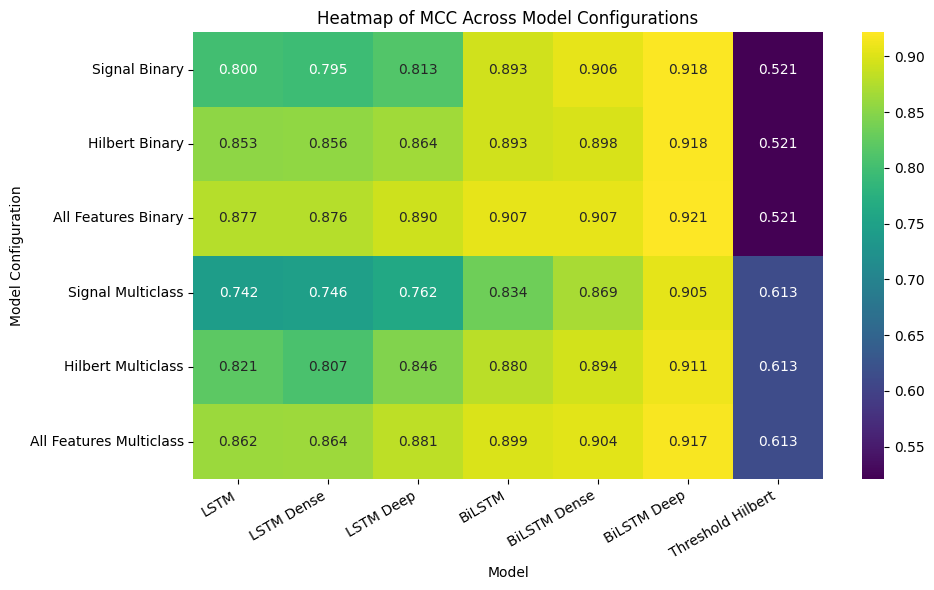

In [8]:

# Combine all dataframes into a list
all_dfs = [signal_binary_df, hilbert_binary_df,  allF_binary_df, signal_multiclass_df, hilbert_multiclass_df, allF_multiclass_df]
df_names = ["Signal Binary", "Hilbert Binary", "All Features Binary", "Signal Multiclass", "Hilbert Multiclass", "All Features Multiclass"]

create_heatmap_from_dfs(all_dfs, df_names, metric="MCC", rows_to_remove=['Threshold NeuroDSP'])
# plot_model_comparison(all_dfs, df_names, metric="MCC", fixed_y=False)

It is a bit shocking how good the models are at signal only multi class detection. I will have to look into that.

In [ ]:
wavelet_binary.keys()

dict_keys(['Accuracy', 'MCC', 'Train Time (s)', 'Inference Time (s/sample)', 'Training Accuracy', 'Training Loss', 'Validation MCC', 'Validation Accuracy', 'Validation Loss', 'Parameters'])

Num Epochs [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Num Epochs [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Num Epochs [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Num Epochs [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


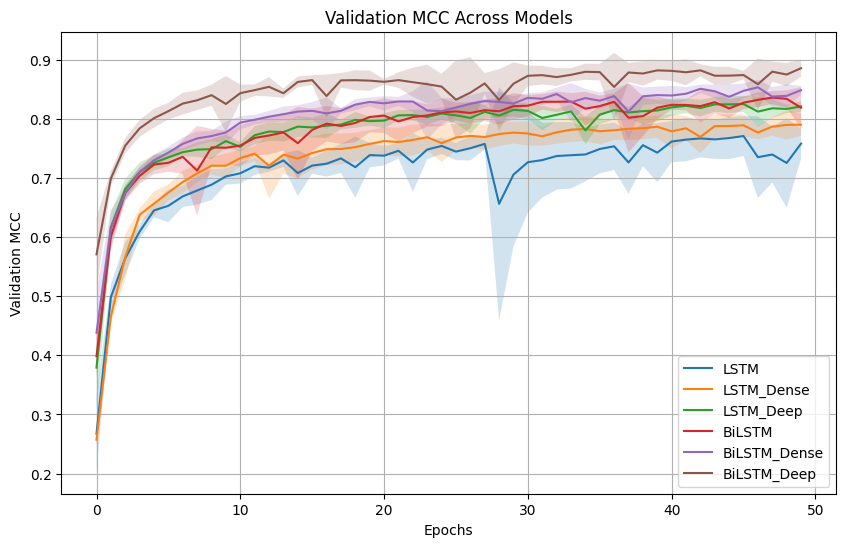

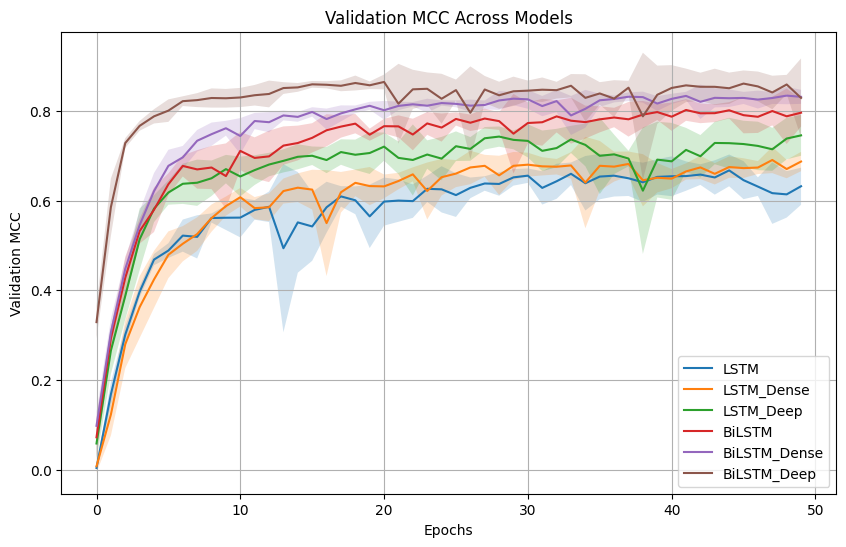

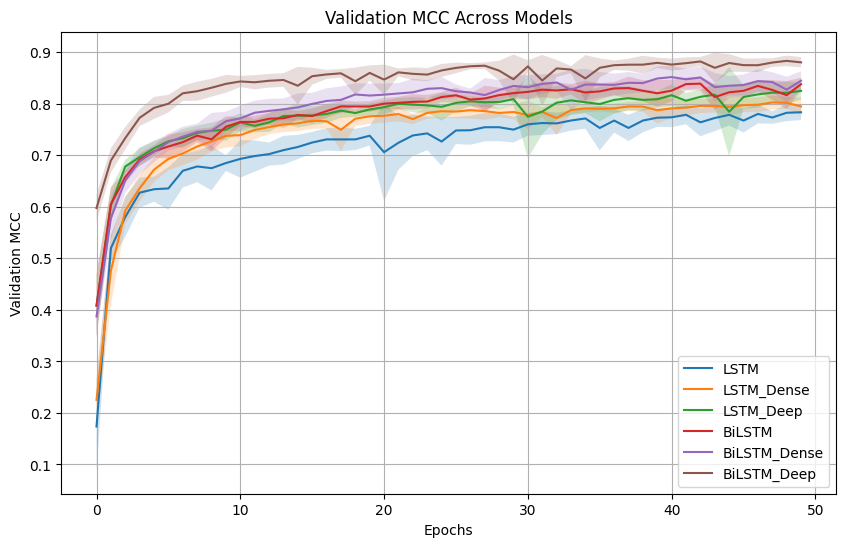

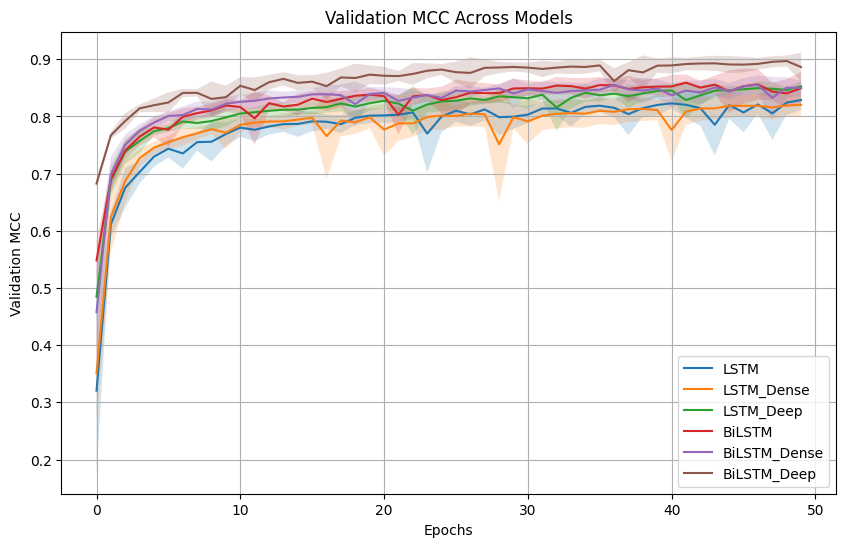

In [ ]:


# Plot both Accuracy and MCC
plot_training_history(hilbert_multiclass, metric="Validation MCC") # 30 Epochs
plot_training_history(signal_multiclass, metric="Validation MCC") # 50 statt 30 Epochs
plot_training_history(wavelet_multiclass, metric="Validation MCC") # 30 Epochs
plot_training_history(allF_multiclass, metric="Validation MCC") # 30 Epcohs



## Plotting Performances LSTMs

In [ ]:
# ML Models
signal_binary_df = format_model_results(signal_binary)
signal_multiclass_df = format_model_results(signal_multiclass)
hilbert_binary_df = format_model_results(hilbert_binary)
hilbert_multiclass_df = format_model_results(hilbert_multiclass)
allF_binary_df = format_model_results(allF_binary)
allF_multiclass_df = format_model_results(allF_multiclass)

# Threshold Models
thresh_binary_df = format_model_results(thresh_binary)
thresh_multiclass_df = format_model_results(thresh_multiclass)
thresh_hilbert_binary_df = format_model_results(thresh_hilbert_binary)
thresh_hilbert_multiclass_df = format_model_results(thresh_hilbert_multi)

# Combine ML Models with Threshold Models
signal_binary_df = pd.concat([signal_binary_df, thresh_binary_df], axis=0)
signal_multiclass_df = pd.concat([signal_multiclass_df, thresh_multiclass_df], axis=0)

hilbert_binary_df = pd.concat([hilbert_binary_df, thresh_hilbert_binary_df], axis=0)
hilbert_multiclass_df = pd.concat([hilbert_multiclass_df, thresh_hilbert_multiclass_df], axis=0)
allF_binary_df = pd.concat([allF_binary_df, thresh_hilbert_binary_df], axis=0)
allF_multiclass_df = pd.concat([allF_multiclass_df, thresh_hilbert_multiclass_df], axis=0)

In [ ]:
allF_binary_df

,Accuracy,MCC,Train Time (s),Inference Time (ms),Parameters
LSTM,0.9277 ± 0.0055,0.8552 ± 0.0111,44.11 ± 0.84,1.62 ± 0.27,5153
LSTM_Dense,0.9285 ± 0.0057,0.8566 ± 0.0113,47.05 ± 3.89,1.83 ± 0.23,5665
LSTM_Deep,0.9353 ± 0.0054,0.8704 ± 0.0109,87.77 ± 8.32,3.08 ± 0.61,31393
BiLSTM,0.9409 ± 0.0067,0.8816 ± 0.0133,91.50 ± 3.32,3.40 ± 0.31,10305
BiLSTM_Dense,0.9443 ± 0.0060,0.8884 ± 0.0119,84.76 ± 2.76,3.60 ± 0.08,11297
BiLSTM_Deep,0.9535 ± 0.0058,0.9068 ± 0.0115,149.75 ± 2.27,3.64 ± 0.30,79137
Threshold NeuroDSP,0.6273 ± 0.0018,0.2656 ± 0.0037,0.00 ± 0.00,4.06 ± 1.17,N/A
Threshold Hilbert,0.7585 ± 0.0029,0.5161 ± 0.0062,0.00 ± 0.00,0.37 ± 0.10,N/A


In [ ]:
signal_binary_df.keys()

Index(['Accuracy', 'MCC', 'Train Time (s)', 'Inference Time (ms)',
       'Parameters'],
      dtype='object')

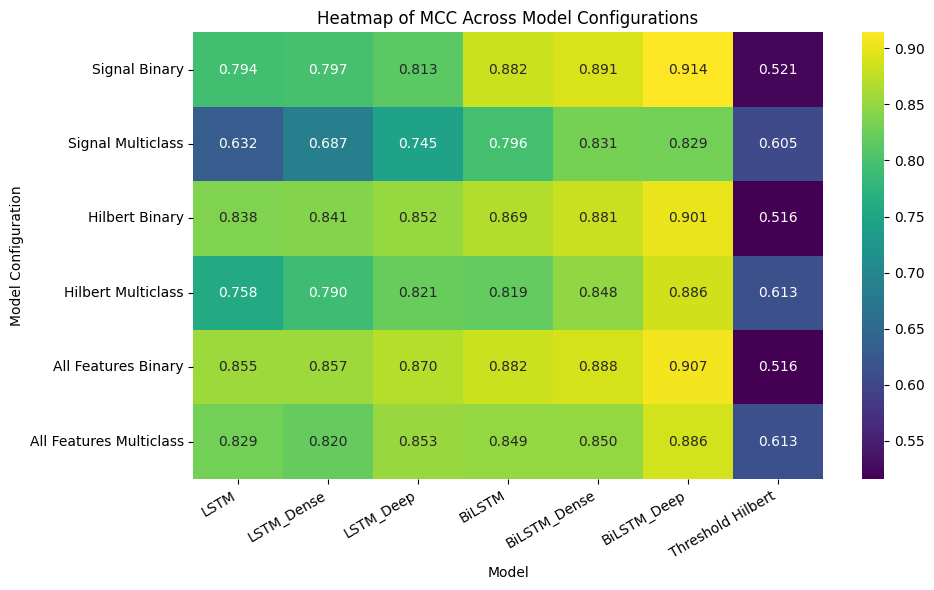

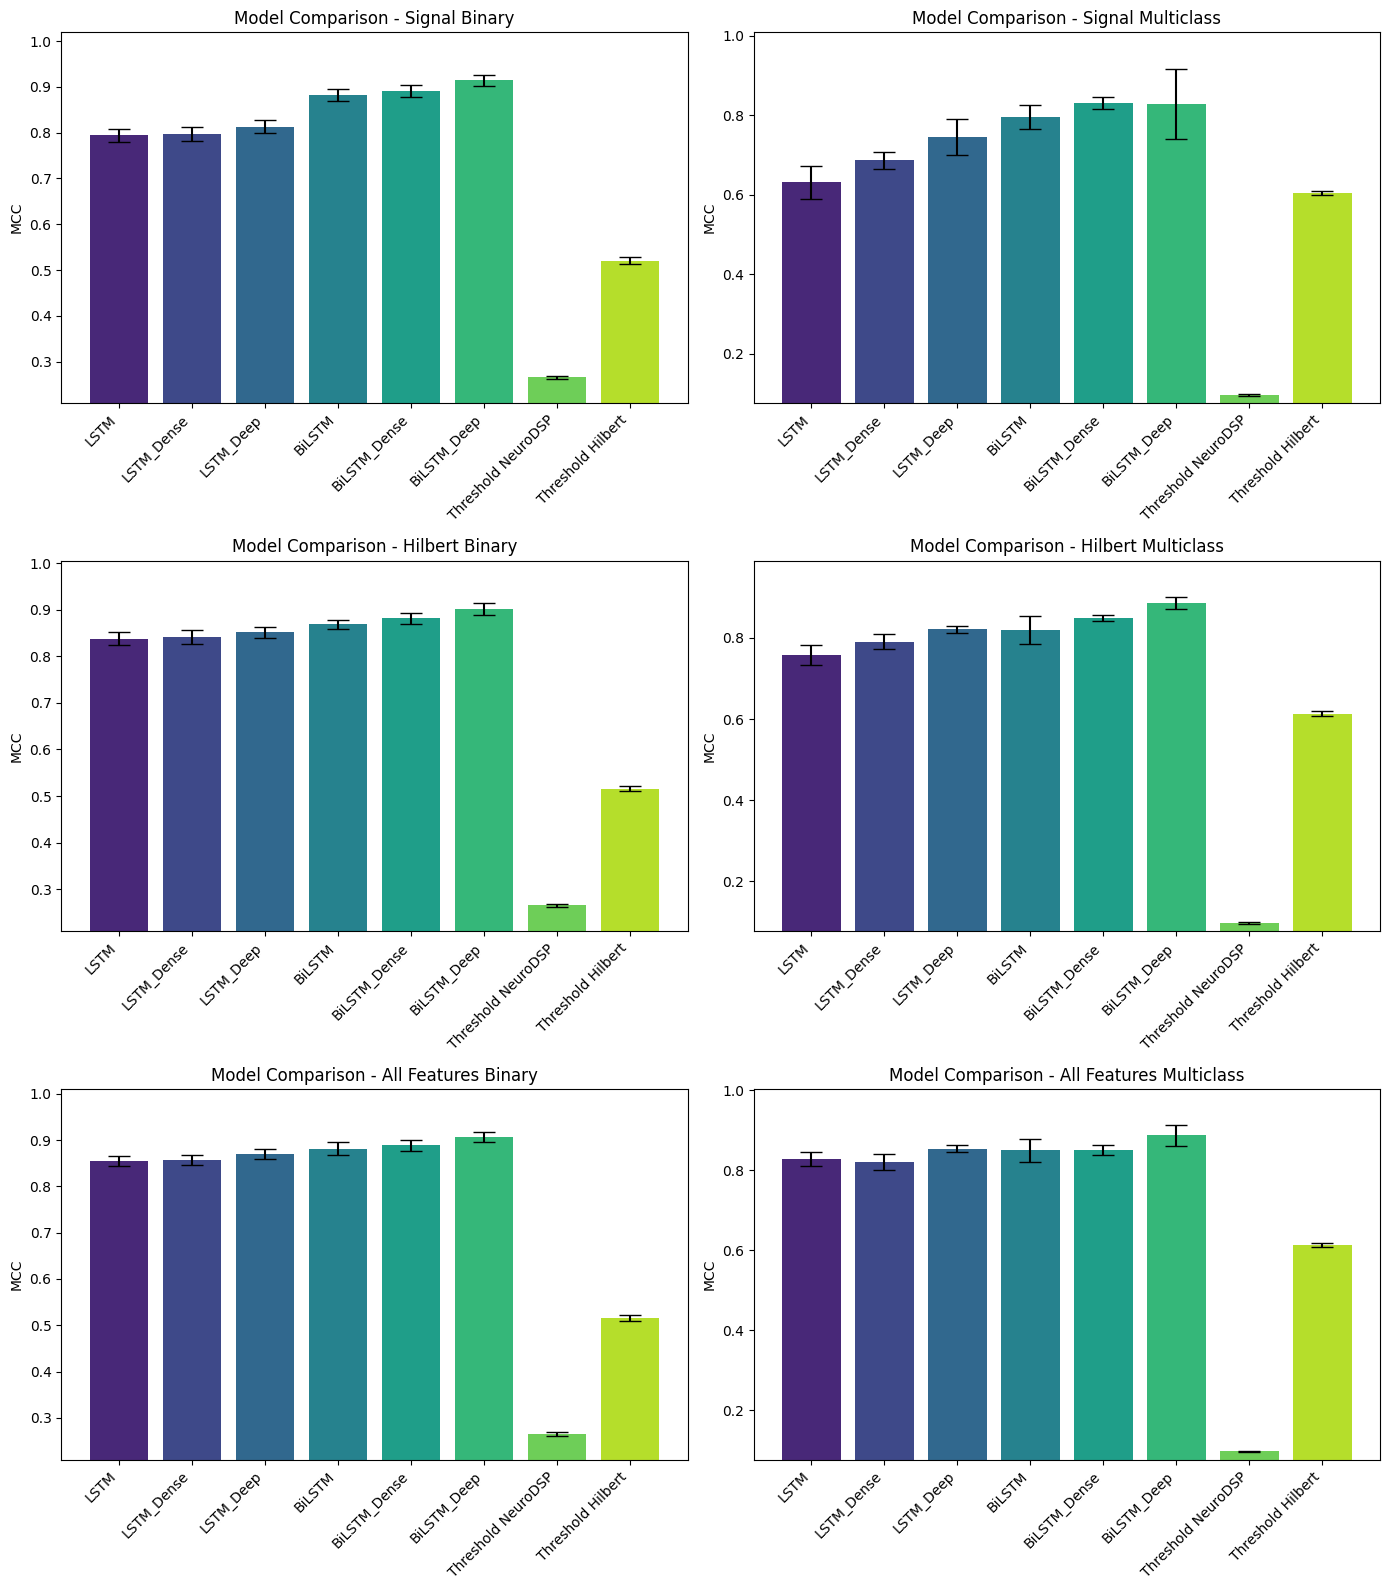

In [ ]:

# Combine all dataframes into a list
all_dfs = [signal_binary_df, signal_multiclass_df, hilbert_binary_df, hilbert_multiclass_df, allF_binary_df, allF_multiclass_df]
df_names = ["Signal Binary", "Signal Multiclass", "Hilbert Binary", "Hilbert Multiclass", "All Features Binary", "All Features Multiclass"]

create_heatmap_from_dfs(all_dfs, df_names, metric="MCC", rows_to_remove=["Threshold NeuroDSP"])
plot_model_comparison(all_dfs, df_names, metric="MCC", fixed_y=False)

In [ ]:
signal_binary['LSTM'].keys()

dict_keys(['Accuracy', 'MCC', 'Train Time (s)', 'Inference Time (s/sample)', 'Training Accuracy', 'Training Loss', 'Validation MCC', 'Validation Accuracy', 'Validation Loss', 'Parameters'])

# Plotting Sample Data

### Creating Threshold Model

In [ ]:
# Import burst detection functions
from neurodsp.burst import detect_bursts_dual_threshold, compute_burst_stats

# Import simulation code for creating test data
from neurodsp.sim import sim_combined
from neurodsp.utils import set_random_seed, create_times

# Import utilities for loading and plotting data
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.time_series import plot_time_series, plot_bursts

In [ ]:
from scipy.signal import hilbert
from scipy.signal import butter, filtfilt

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Applies a Butterworth bandpass filter to the signal data.

    Args:
        data (np.ndarray): The input signal.
        lowcut (float): Lower cutoff frequency in Hz.
        highcut (float): Upper cutoff frequency in Hz.
        fs (float): Sampling frequency in Hz.
        order (int, optional): Order of the filter. Defaults to 4.

    Returns:
        np.ndarray: The filtered signal.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Applies a butter bandpass filter
    b, a = butter(order, [low, high], btype='band')
    # Applies digital filter to minimize distortion introduced by the filters.
    y = filtfilt(b, a, data)
    return y

# Step 1: Compute the Hilbert transform amplitude for the signal
def compute_hilbert_features(X, fs=250):  # Accepts 3D input X
    """
    Computes Hilbert amplitude features with frequency-dependent filter orders and smoothing.
    Flattens the input, computes amplitudes, and reshapes back to the original shape.

    Args:
        X (np.ndarray): The input signal data (3D array).
        fs (int, optional): Sampling frequency. Defaults to 250.

    Returns:
        np.ndarray: The Hilbert amplitude features (3D array with the same shape as input X).
    """
    original_shape = X.shape

    # Flatten the input data
    signal_flat = X.flatten()

    # Define frequency bands with filter orders and smoothing factors
    frequency_bands = {
        'theta': (4, 7, 2, 0.0),  # (lowcut, highcut, filter_order, smoothing_factor)
        'alpha': (8, 11, 2, 0.0),
        'beta': (12, 28, 6, 0.3),
        'gamma': (30, 100, 8, 0.4)
    }

    hilbert_features = []

    for band_name, (lowcut, highcut, filter_order, smoothing_factor) in frequency_bands.items():
        # Apply bandpass filter with specified order
        filtered_signal = butter_bandpass_filter(signal_flat, lowcut, highcut, fs, order=filter_order)

        # Compute Hilbert amplitude envelope
        amplitude_envelope = np.abs(hilbert(filtered_signal))

        # Apply smoothing (e.g., moving average) only if smoothing_factor > 0
        if smoothing_factor > 0:
            window_size = int(smoothing_factor * fs)  # Adjust window size based on frequency and smoothing factor
            amplitude_envelope = np.convolve(amplitude_envelope, np.ones(window_size) / window_size, mode='same')
        print(band_name, amplitude_envelope.shape)
        hilbert_features.append(amplitude_envelope)

    # Reshape the features back to the original 3D shape
    hilbert_features_3d = np.column_stack(hilbert_features).reshape(original_shape + (4,))  # Add feature dimension
    print(hilbert_features_3d.shape)
    return hilbert_features_3d

In [ ]:
import numpy as np
from neurodsp.burst import detect_bursts_dual_threshold
from neurodsp.filt import filter_signal

import numpy as np
from neurodsp.burst import detect_bursts_dual_threshold
from neurodsp.filt import filter_signal


def detect_bursts_neuroDSP(X, fs=250, bands=[(4, 8), (8, 12), (12, 30), (30, 50)], amp_low=1, amp_high=2, is_binary=None, n_cycles=3):  # Added n_cycles parameter
    """
    Detect bursts using `detect_bursts_dual_threshold` applied per frequency band.

    :param X: Input data of shape (samples, seq_len, n_features)
    :param fs: Sampling rate
    :param bands: Frequency bands for burst detection
    :param amp_low: Lower amplitude threshold
    :param amp_high: Higher amplitude threshold
    :param is_binary: Auto-detect classification type if None
    :param n_cycles: Number of cycles to use for filter design (adjust to shorten filter)
    :return: Binary or multiclass burst predictions (samples, seq_len)
    """
    samples, seq_len, n_features = X.shape

    if is_binary is None:
        is_binary = n_features == 1

    num_bands = len(bands)
    burst_detections = np.zeros((samples, seq_len, num_bands), dtype=int)

    for i, (low_f, high_f) in enumerate(bands):
        f_range = (low_f, high_f)
        for j in range(samples):
            # Pass n_cycles to detect_bursts_dual_threshold to control filter length
            burst_detections[j, :, i] = detect_bursts_dual_threshold(X[j,:,i], fs, (amp_low, amp_high), (low_f, high_f))

    if is_binary:
        return (burst_detections.any(axis=-1)).astype(int)  # Binary: Any band active → 1
    else:
        return np.argmax(burst_detections, axis=-1)  # Multiclass: Assign highest active bandd

import numpy as np

def detect_bursts_hilbert(X, std_factor=1, is_binary=None, fs=250):
    """
    Detect bursts using Hilbert amplitude envelopes with thresholding.

    :param X: Precomputed Hilbert envelopes of shape (samples, seq_len, 4: n_features)
    :param std_factor: Standard deviation factor for thresholding
    :param is_binary: Auto-detect classification type if None
    :return: Binary or multiclass burst predictions (samples, seq_len)
    """
    samples, seq_len, n_features = X.shape

    if n_features == 1:
        X = compute_hilbert_features(X.reshape(samples, seq_len), fs=fs)

    # Compute dynamic thresholds for each feature (mean + std_factor * std)
    mean_values = np.mean(X, axis=(0, 1))  # Mean per feature
    std_values = np.std(X, axis=(0, 1))  # Std per feature
    thresholds = mean_values + std_factor * std_values  # Dynamic threshold per feature

    # Detect bursts per feature
    burst_detections = X > thresholds  # Boolean mask of detected bursts

    # Find the strongest amplitude per timestep across all features
    max_amplitude_band = np.argmax(X, axis=-1)  # (samples, seq_len)

    # Enforce the highest amplitude rule: Remove all bursts except the strongest one
    final_burst_labels = np.zeros((samples, seq_len), dtype=int)  # Default: Noise (0)
    for i in range(samples):
        for t in range(seq_len):
            strongest_band = max_amplitude_band[i, t]  # Identify the strongest amplitude band

            # If this band also crosses the burst threshold, assign it as the final label
            if burst_detections[i, t, strongest_band]:
                final_burst_labels[i, t] = strongest_band + 1  # Shift labels (Theta = 1, Alpha = 2, etc.)

    if is_binary:
        return (final_burst_labels > 0).astype(int)  # Convert to 0/1 for binary classification
    else:
        return final_burst_labels  # Multiclass classification (0-4)


# Example Usage
np.random.seed(42)
X_test = np.random.rand(20, 500, 5)  # Fake test data (20 samples, 500 timesteps, 4 features)

# Using Dual Threshold on Filtered Bands
binary_preds_dual = detect_bursts_neuroDSP(X_test, is_binary=True)
multiclass_preds_dual = detect_bursts_neuroDSP(X_test, is_binary=False)

# Using Hilbert Envelopes (Assuming They Are Precomputed)
binary_preds_hilbert = detect_bursts_hilbert(X_test, is_binary=True)
multiclass_preds_hilbert = detect_bursts_hilbert(X_test, is_binary=False)

print(f"Binary Predictions (Dual): {binary_preds_dual.shape} (Expected (20, 500))")
print(f"Multiclass Predictions (Dual): {multiclass_preds_dual.shape} (Expected (20, 500))")

print(f"Binary Predictions (Hilbert): {binary_preds_hilbert.shape} (Expected (20, 500))")
print(f"Multiclass Predictions (Hilbert): {multiclass_preds_hilbert.shape} (Expected (20, 500))")


Binary Predictions (Dual): (20, 500) (Expected (20, 500))
Multiclass Predictions (Dual): (20, 500) (Expected (20, 500))
Binary Predictions (Hilbert): (20, 500) (Expected (20, 500))
Multiclass Predictions (Hilbert): (20, 500) (Expected (20, 500))


### Load and Shape Data

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/Including Features/5_class_mid_noise_30s_features_vec.npy"
label_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/Including Features/5_class_mid_noise_30s_numeric_label_vec.npy"

data_vec, label_vec = du.load_data(data_path, label_path)

In [ ]:
# Get Last Sample. That one the models havent seen yet
data_vec_trim = data_vec[-1:, :, :]
label_vec_trim = label_vec[-1:, :, :]

print(data_vec_trim.shape)
print(label_vec_trim.shape)

(1, 20, 5, 7500, 25)
(1, 20, 5, 7500)


In [ ]:
# Extract data and labels for different noise levels
data_very_high_noise = data_vec_trim[:, :, 0]
label_very_high_noise = label_vec_trim[:, :, 0]

data_high_noise = data_vec_trim[:, :, 1]
label_high_noise = label_vec_trim[:, :, 1]

data_mid_noise = data_vec_trim[:, :, 2]
label_mid_noise = label_vec_trim[:, :, 2]

data_low_noise = data_vec_trim[:, :, 3]
label_low_noise = label_vec_trim[:, :, 3]

data_very_low_noise = data_vec_trim[:, :, 4]
label_very_low_noise = label_vec_trim[:, :, 4]

# Now you have 5 sets for data and labels:
# - data_very_high_noise, label_very_high_noise
# - data_high_noise, label_high_noise
# - data_mid_noise, label_mid_noise
# - data_low_noise, label_low_noise
# - data_very_low_noise, label_very_low_noise

In [ ]:
def reshape_vector(vector):
        """Helper function to reshape a single vector."""
        if vector.ndim == 2:  # (S, timesteps)
            # Reshape 2D to 3D by adding a feature dimension with I = 1
            vector = vector.reshape(vector.shape[0], vector.shape[1], 1)
        elif vector.ndim == 3:
            if vector.shape[1] < 1000 and vector.shape[2] >= 1000:  # (S, F, timesteps)
                # Assume timesteps is the last dimension, move it to the second position
                N = vector.shape[0] * vector.shape[1]
                vector = vector.reshape(N, vector.shape[-1], 1)
            # else: (S, timesteps, I) - already in desired format
        elif vector.ndim == 4:
            if vector.shape[2] < 1000 and vector.shape[3] >= 1000:  # (S, F, N, timesteps)
                # Reshape by flattening the first three dimensions
                N = vector.shape[0] * vector.shape[1] * vector.shape[2]
                vector = vector.reshape(N, vector.shape[3], 1)
            # Assume its (S, F, timesteps, I), flatten first 2 to get (N, timesteps, I)
            elif vector.shape[2] >= 1000 and vector.shape[3] < 1000:
                N = vector.shape[0] * vector.shape[1]
                vector = vector.reshape(N, vector.shape[2], vector.shape[3])
            else:
                raise ValueError("4D input shape not recognized. Please check the dimensions.")
        elif vector.ndim == 5:  # (S, F, N, timesteps, I)
            # Reshape by flattening the first three dimensions
            N = vector.shape[0] * vector.shape[1] * vector.shape[2]
            vector = vector.reshape(N, vector.shape[3], vector.shape[4])
        else:
            raise ValueError("Input vector must be 2D, 3D, 4D, or 5D.")
        return vector

In [ ]:
# Mid noise example data

data_mid_noise_reshaped = reshape_vector(data_vec_trim)
label_mid_noise_reshaped = reshape_vector(label_vec_trim)

print(data_mid_noise_reshaped.shape)
print(label_mid_noise_reshaped.shape)

data_vec_reshaped, label_vec_reshaped = du.split_sequences_keep_data(data_mid_noise_reshaped, label_mid_noise_reshaped, new_seq_len=1500)


(100, 7500, 25)
(100, 7500, 1)


In [ ]:

print(data_vec_reshaped.shape)
print(label_vec_reshaped.shape)

(500, 1500, 25)
(500, 1500, 1)


In [ ]:
label_multi = label_vec_reshaped
label_binary = label_vec_reshaped.copy()
label_binary[label_binary >= 1] = 1  # Convert to binary labels

print(label_multi.shape)
print(label_binary.shape)

(500, 1500, 1)
(500, 1500, 1)


### Threshold Detecting Sample Bursts

In [ ]:
## Algorithmic Burst Detection
y_pred_neurdsp = detect_bursts_neuroDSP(data_vec_reshaped[:,:,1:5], is_binary=True)

y_pred_neurdsp_multi = detect_bursts_neuroDSP(data_vec_reshaped[:,:,1:5], is_binary=False)

y_pred_hilbert = detect_bursts_hilbert(data_vec_reshaped[:,:,1:5], is_binary=True)
y_pred_hilbert_multi = detect_bursts_hilbert(data_vec_reshaped[:,:,1:5], is_binary=False)

y_pred_hilbert_signal = detect_bursts_hilbert(data_vec_reshaped[:,:,:1], is_binary=True)
y_pred_hilbert_multi_signal = detect_bursts_hilbert(data_vec_reshaped[:,:,:1], is_binary=False)


theta (750000,)
alpha (750000,)
beta (750000,)
gamma (750000,)
(500, 1500, 4)
theta (750000,)
alpha (750000,)
beta (750000,)
gamma (750000,)
(500, 1500, 4)


In [ ]:
from sklearn.metrics import matthews_corrcoef, accuracy_score

y_true = label_vec_reshaped

print('NeuroDSP Threshold (ACC, binary)', accuracy_score(label_binary.flatten(), y_pred_neurdsp.flatten()))
print('NeuroDSP Threshold (MCC, binary)', matthews_corrcoef(label_binary.flatten(), y_pred_neurdsp.flatten()))
print('NeuroDSP Threshold (ACC, multi)', accuracy_score(label_multi.flatten(), y_pred_neurdsp_multi.flatten()))
print('NeuroDSP Threshold (MCC, multi)', matthews_corrcoef(label_multi.flatten(), y_pred_neurdsp_multi.flatten()))

print('Hilbert Threshold Simple (ACC, binary)', accuracy_score(label_binary.flatten(), y_pred_hilbert_signal.flatten()))
print('Hilbert Threshold Simple (MCC, binary)', matthews_corrcoef(label_binary.flatten(), y_pred_hilbert_signal.flatten()))
print('Hilbert Threshold Simple (ACC, multi)', accuracy_score(label_multi.flatten(), y_pred_hilbert_multi_signal.flatten()))
print('Hilbert Threshold Simple (MCC, multi)', matthews_corrcoef(label_multi.flatten(), y_pred_hilbert_multi_signal.flatten()))


print('Hilbert Threshold (ACC, binary)', accuracy_score(label_binary.flatten(), y_pred_hilbert.flatten()))
print('Hilbert Threshold (MCC, binary)', matthews_corrcoef(label_binary.flatten(), y_pred_hilbert.flatten()))
print('Hilbert Threshold (ACC, multi)', accuracy_score(label_multi.flatten(), y_pred_hilbert_multi.flatten()))
print('Hilbert Threshold (MCC, multi)', matthews_corrcoef(label_multi.flatten(), y_pred_hilbert_multi.flatten()))

NeuroDSP Threshold (ACC, binary) 0.5202
NeuroDSP Threshold (MCC, binary) 0.008342442731097788
NeuroDSP Threshold (ACC, multi) 0.444812
NeuroDSP Threshold (MCC, multi) -0.0027369706102469203
Hilbert Threshold Simple (ACC, binary) 0.7718186666666667
Hilbert Threshold Simple (MCC, binary) 0.5407142192543644
Hilbert Threshold Simple (ACC, multi) 0.7583426666666667
Hilbert Threshold Simple (MCC, multi) 0.6290818231773646
Hilbert Threshold (ACC, binary) 0.7721866666666667
Hilbert Threshold (MCC, binary) 0.5414500986590952
Hilbert Threshold (ACC, multi) 0.7531306666666666
Hilbert Threshold (MCC, multi) 0.6204336396838905


In [ ]:
from sklearn.metrics import classification_report
print("Binary Classification Report:")
print(classification_report(label_binary.flatten(), y_pred_hilbert.flatten()))

print("Multiclass Classification Report:")
print(classification_report(label_multi.flatten(), y_pred_hilbert_multi.flatten()))

Binary Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79    400131
           1       0.77      0.73      0.75    349869

    accuracy                           0.77    750000
   macro avg       0.77      0.77      0.77    750000
weighted avg       0.77      0.77      0.77    750000

Multiclass Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79    400131
           1       0.73      0.69      0.71     88952
           2       0.74      0.60      0.66     87939
           3       0.75      0.79      0.77     88948
           4       0.70      0.65      0.67     84030

    accuracy                           0.75    750000
   macro avg       0.74      0.71      0.72    750000
weighted avg       0.75      0.75      0.75    750000



In [ ]:
y_pred_hilbert.shape

(500, 1500)

In [ ]:
# Example usage:
predicted_data = y_pred_hilbert[:, :, np.newaxis]   # Replace N with the actual value
original_shape = (1, 20, 5, 7500, 1)

reshaped_predictions_hilbert = reshape_predicted_data(predicted_data, original_shape)
reshaped_label = reshape_predicted_data(label_binary, original_shape)
print(reshaped_predictions.shape)  # Output: (1, 20, 5, 7500, 1)

NameError: name 'reshape_predicted_data' is not defined

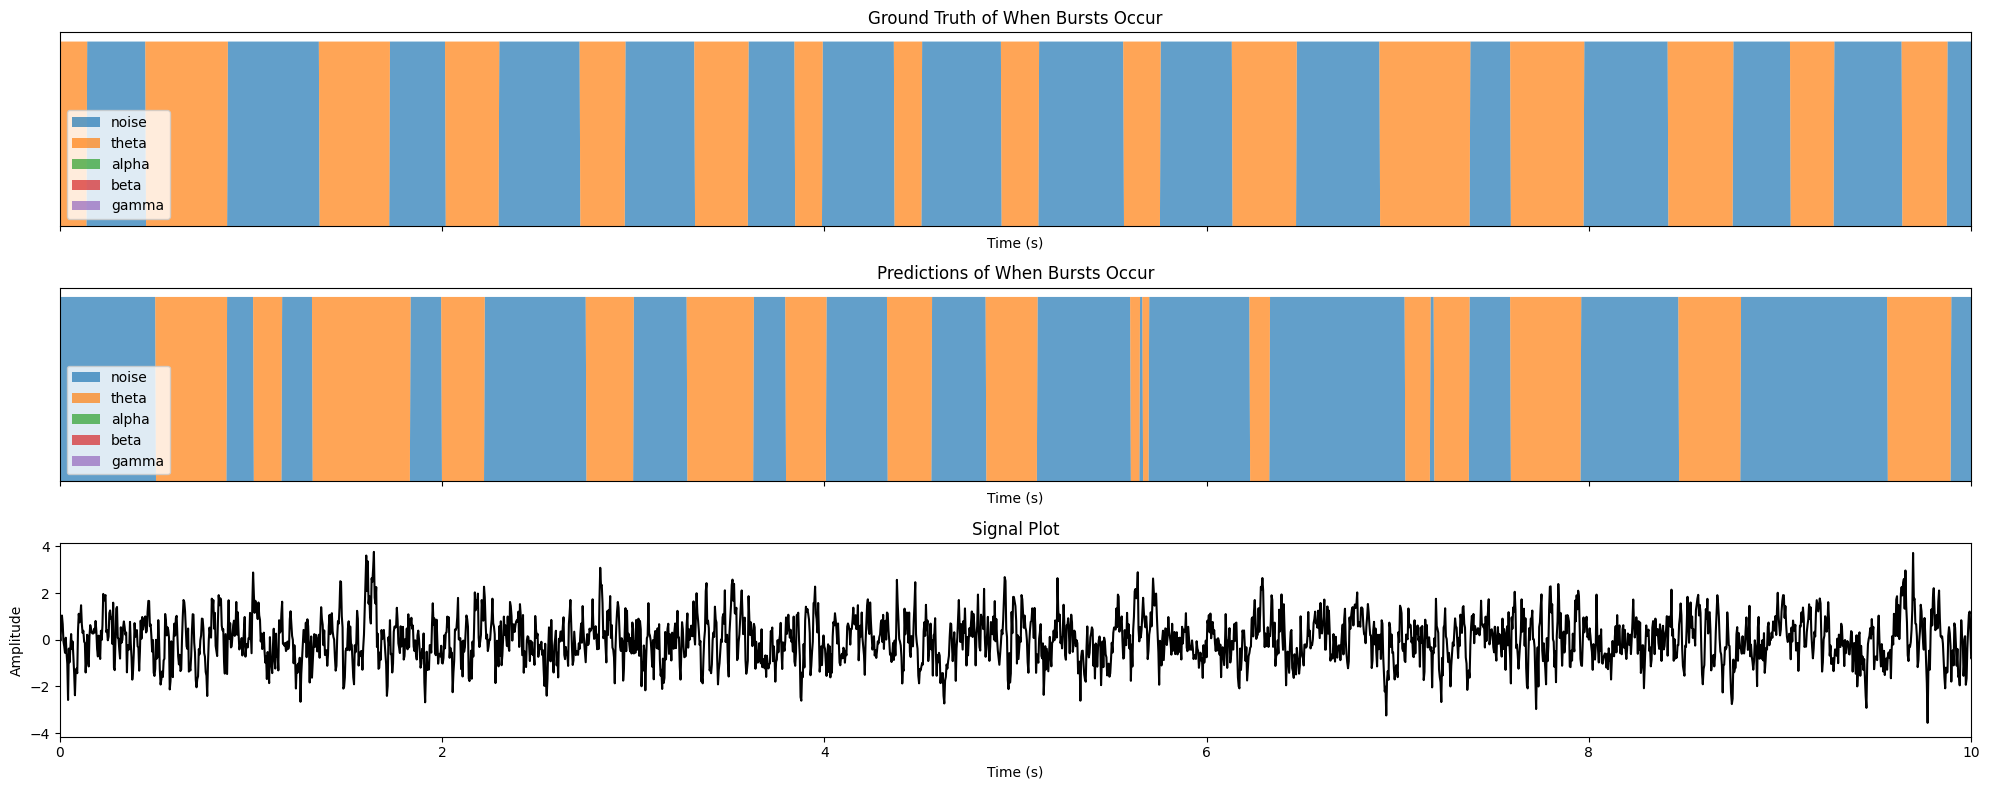

In [ ]:
sample = 0 # Only Sample available
freq = 10
noise = 1
num_features = 1

signal_sample = data_vec_trim[sample,freq,noise, : , :1]
hilbert_sample = data_vec_trim[sample,freq,noise, : , 1:5]

visualize_training_data(reshaped_label[sample,freq,noise], signal_sample, reshaped_predictions_hilbert[sample,freq,noise])

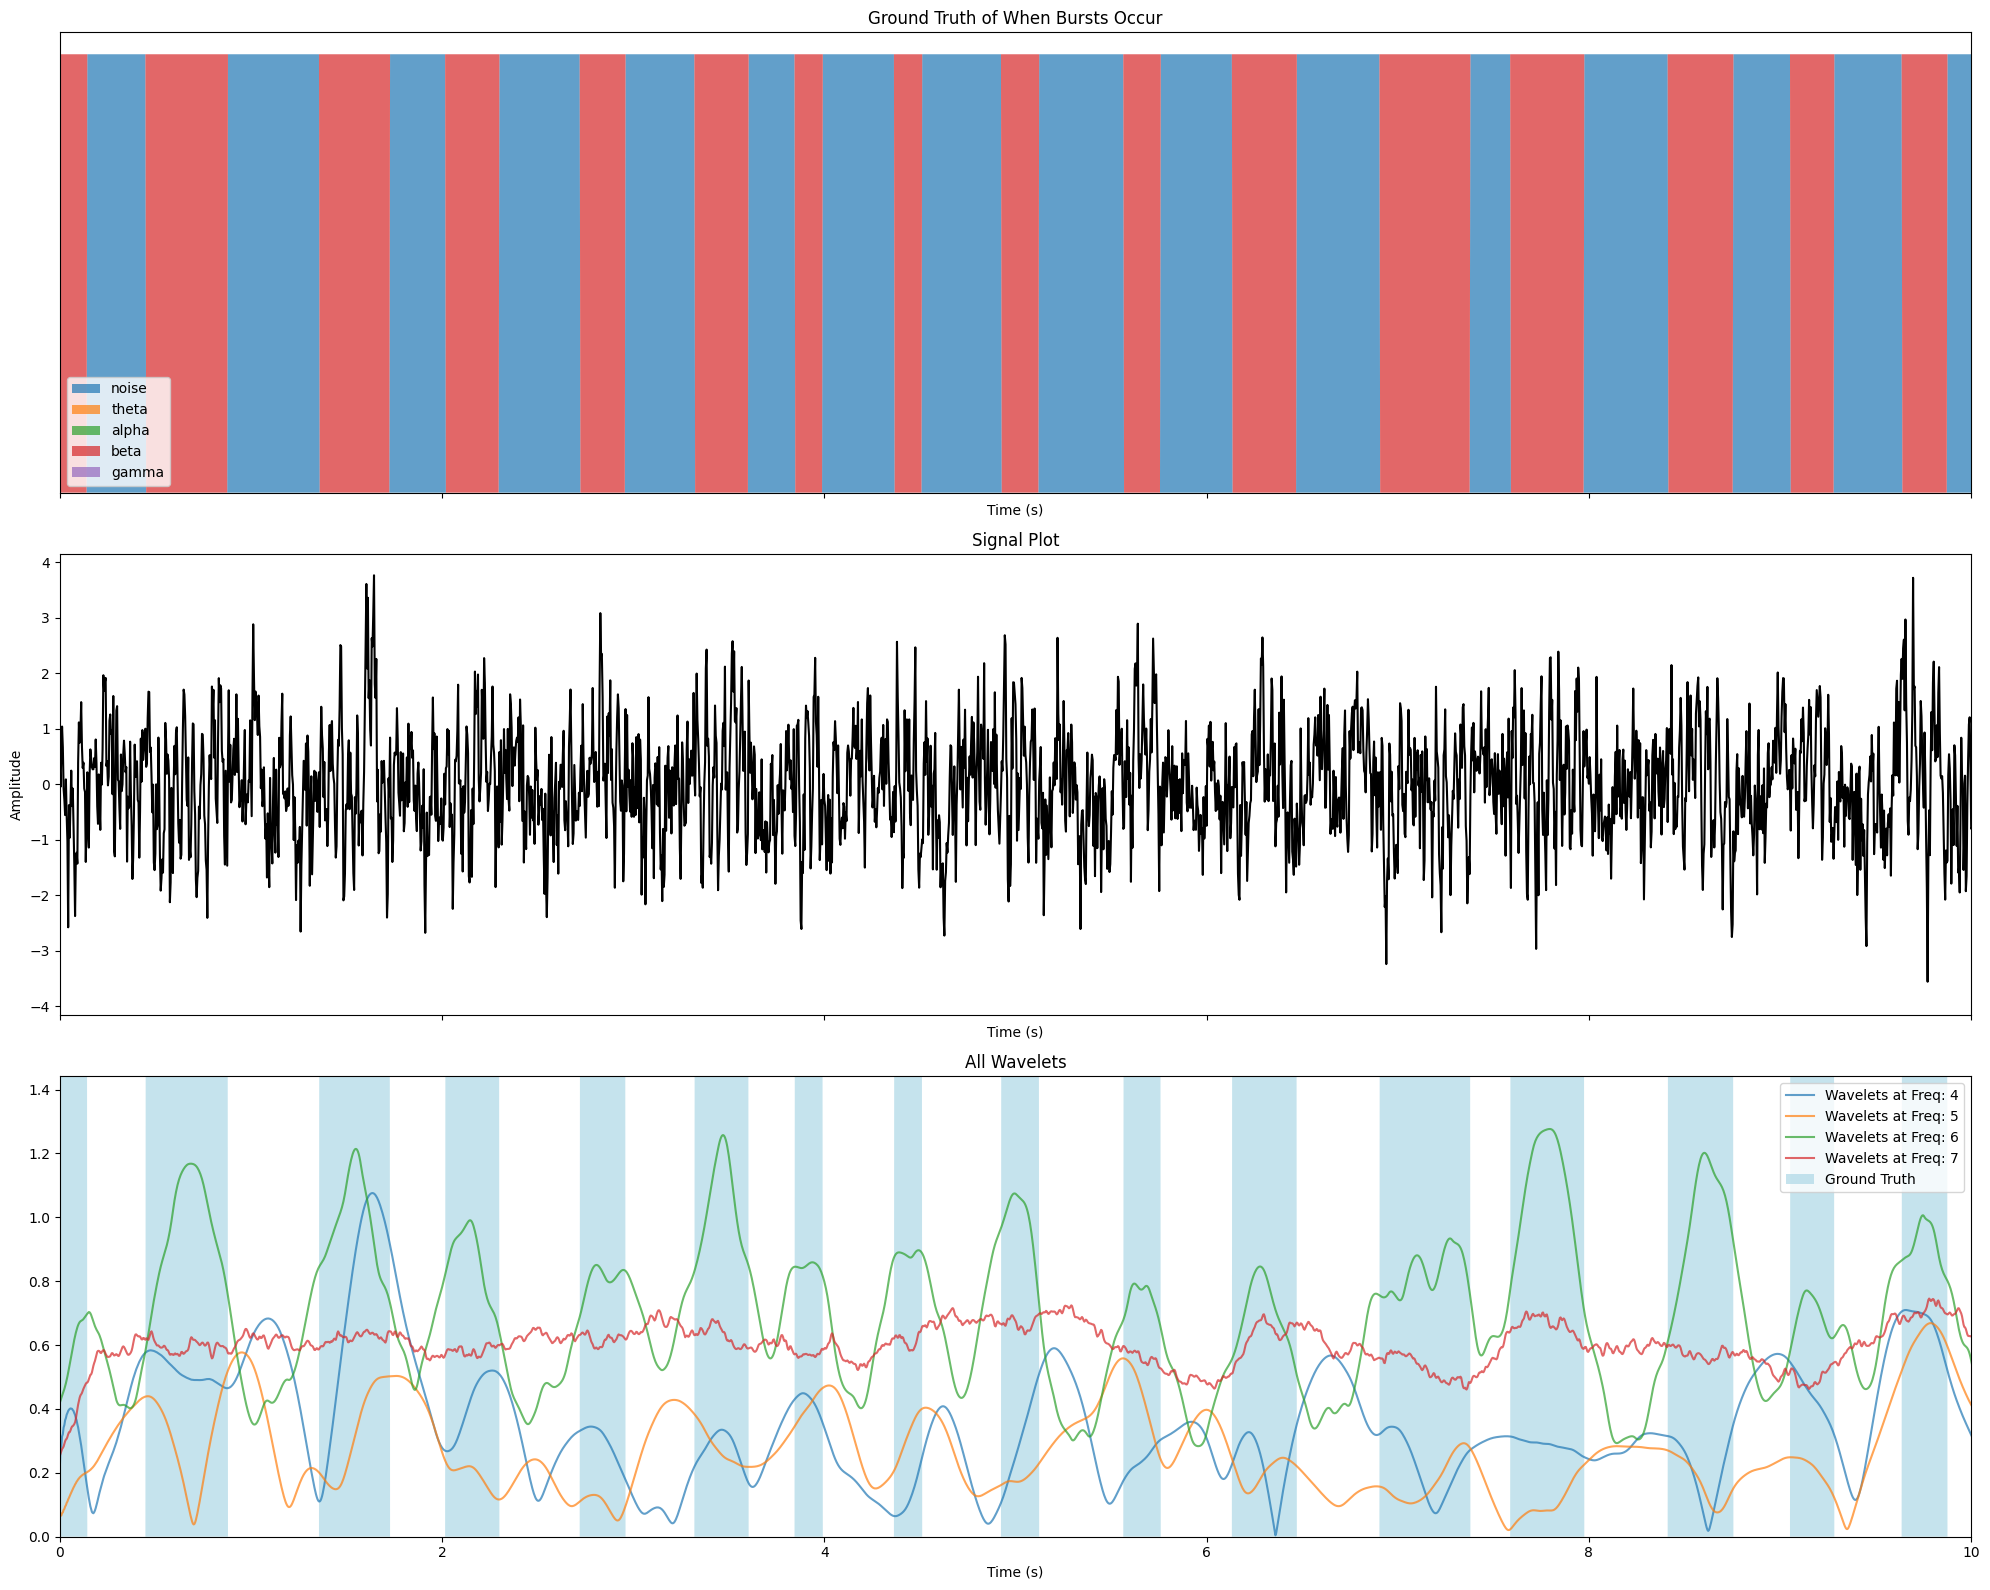

In [ ]:
du.visualize_feature_data(label_vec_trim[sample,freq,noise], signal_sample, hilbert_sample, duration=30, time_window=(0, 10),
                       category_labels=['noise', 'theta', 'alpha', 'beta', 'gamma'])

### Loading the models

We have odd behavior in Beta Binary model results.
- The implemented features appeared to have little to no impact.
- Especially for BiLSTMs \\
Analyze the following models predictions:
1. BiLSTM (signal and allF)
2. LSTM (signal and allF)


In [ ]:
basePath = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/Model Comparisons/LSTM Models/"
signal_binary_path = f"{basePath}signal_binary/"
allF_binary_path = f"{basePath}allF_binary/"

biLSTM_signal_binary_path = f"{signal_binary_path}BiLSTM_Deep/BiLSTM_Deep_final.h5"
biLSTM_signal_allF_path = f"{allF_binary_path}BiLSTM_Deep/BiLSTM_Deep_final.h5"

LSTM_signal_binary_path = f"{signal_binary_path}LSTM/LSTM_final.h5"
LSTM_signal_allF_path = f"{allF_binary_path}LSTM/LSTM_final.h5"


#biLSTM_binary_path = f"{signal_binary_path}BiLSTM/BiLSTM_final.h5"

In [ ]:
# Load the multi-class model
biLSTM_signal_binary = load_model(biLSTM_signal_binary_path)

# Load the binary model
biLSTM_allF_binary = load_model(biLSTM_signal_allF_path)

LSTM_signal_binary = load_model(LSTM_signal_binary_path)

LSTM_allF_binary = load_model(LSTM_signal_allF_path)


In [ ]:
beta_indices = [0,3,12,13,14,15,16]

X_signal = data_vec_reshaped[:,:,:1]
x_allF_beta = data_vec_reshaped[:,:,beta_indices]
y_test = label_vec_reshaped
y_binary = y_test

# Make predictions using the multi-class model
y_pred_signal_binary = biLSTM_signal_binary.predict(X_signal)
#y_pred_signal_binary = (y_pred_signal_binary > 0.5).astype(int)

# Make predictions using the binary model
y_pred_allF_binary = biLSTM_allF_binary.predict(x_allF_beta)
#y_pred_allF_binary = (y_pred_allF_binary > 0.5).astype(int)

y_pred_LSTM_signal_binary = LSTM_signal_binary.predict(X_signal)
#y_pred_LSTM_signal_binary = (y_pred_LSTM_signal_binary > 0.5).astype(int)

y_pred_LSTM_allF = LSTM_allF_binary.predict(x_allF_beta)
#y_pred_LSTM_allF = (y_pred_LSTM_allF > 0.5).astype(int)

# y_pred_multi_FFN = FFN_multi.predict(X_test)
# y_pred_multi_FFN_argmax = np.argmax(y_pred_multi_FFN, axis=-1)

# Get the argmax for the multi-class predictions
# y_pred_multi_argmax = np.argmax(y_pred_multi, axis=-1)

# Make predictions using the binary model
# y_pred_binary = biLSTM_binary.predict(data_vec_reshaped[:,:,:5])

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 910ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 858ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step


In [ ]:
print(y_pred_signal_binary[0, :10])
print(y_pred_allF_binary[0, :10])

[[0.2807548 ]
 [0.2693521 ]
 [0.274081  ]
 [0.26092154]
 [0.28708136]
 [0.30567014]
 [0.27987736]
 [0.2683808 ]
 [0.22979836]
 [0.15637666]]
[[0.3699142 ]
 [0.39554074]
 [0.4052775 ]
 [0.3892036 ]
 [0.37847283]
 [0.35080618]
 [0.29642066]
 [0.24849416]
 [0.20800747]
 [0.18621853]]


In [ ]:
y_pred_allF_binary.shape

(500, 1500, 1)

In [ ]:
import numpy as np

def reshape_predicted_data(predicted_data, original_shape):
    """
    Reshapes predicted data back to the original shape.

    Args:
        predicted_data: The predicted data with shape (N, 500, 1).
        original_shape: The original shape of the data (1, 20, 5, 7500, n_features).

    Returns:
        The reshaped predicted data with the original shape.
    """

    # Get the total number of elements in the predicted data
    total_elements = predicted_data.size

    # Calculate the number of elements per original sample
    elements_per_sample = np.prod(original_shape[1:])  # Product of dimensions 2 to 4

    # Calculate the number of original samples
    num_samples = total_elements // elements_per_sample

    # Reshape the predicted data to the original shape
    reshaped_data = predicted_data.reshape(original_shape)

    return reshaped_data

In [ ]:
# Example usage:
predicted_data = y_pred_signal_binary  # Replace N with the actual value
original_shape = (1, 20, 5, 7500, 1)

reshaped_y_pred_signal = reshape_predicted_data(predicted_data, original_shape)
reshaped_y_pred_allF= reshape_predicted_data(y_pred_allF_binary, original_shape)

reshaped_y_pred_signal_LSTM = reshape_predicted_data(y_pred_LSTM_signal_binary, original_shape)
reshaped_y_pred_allF_LSTM = reshape_predicted_data(y_pred_LSTM_allF, original_shape)

print(reshaped_y_pred_signal.shape)  # Output: (1, 20, 5, 7500, 1)

(1, 20, 5, 7500, 1)


<ipython-input-91-a23bbdb3c931>:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


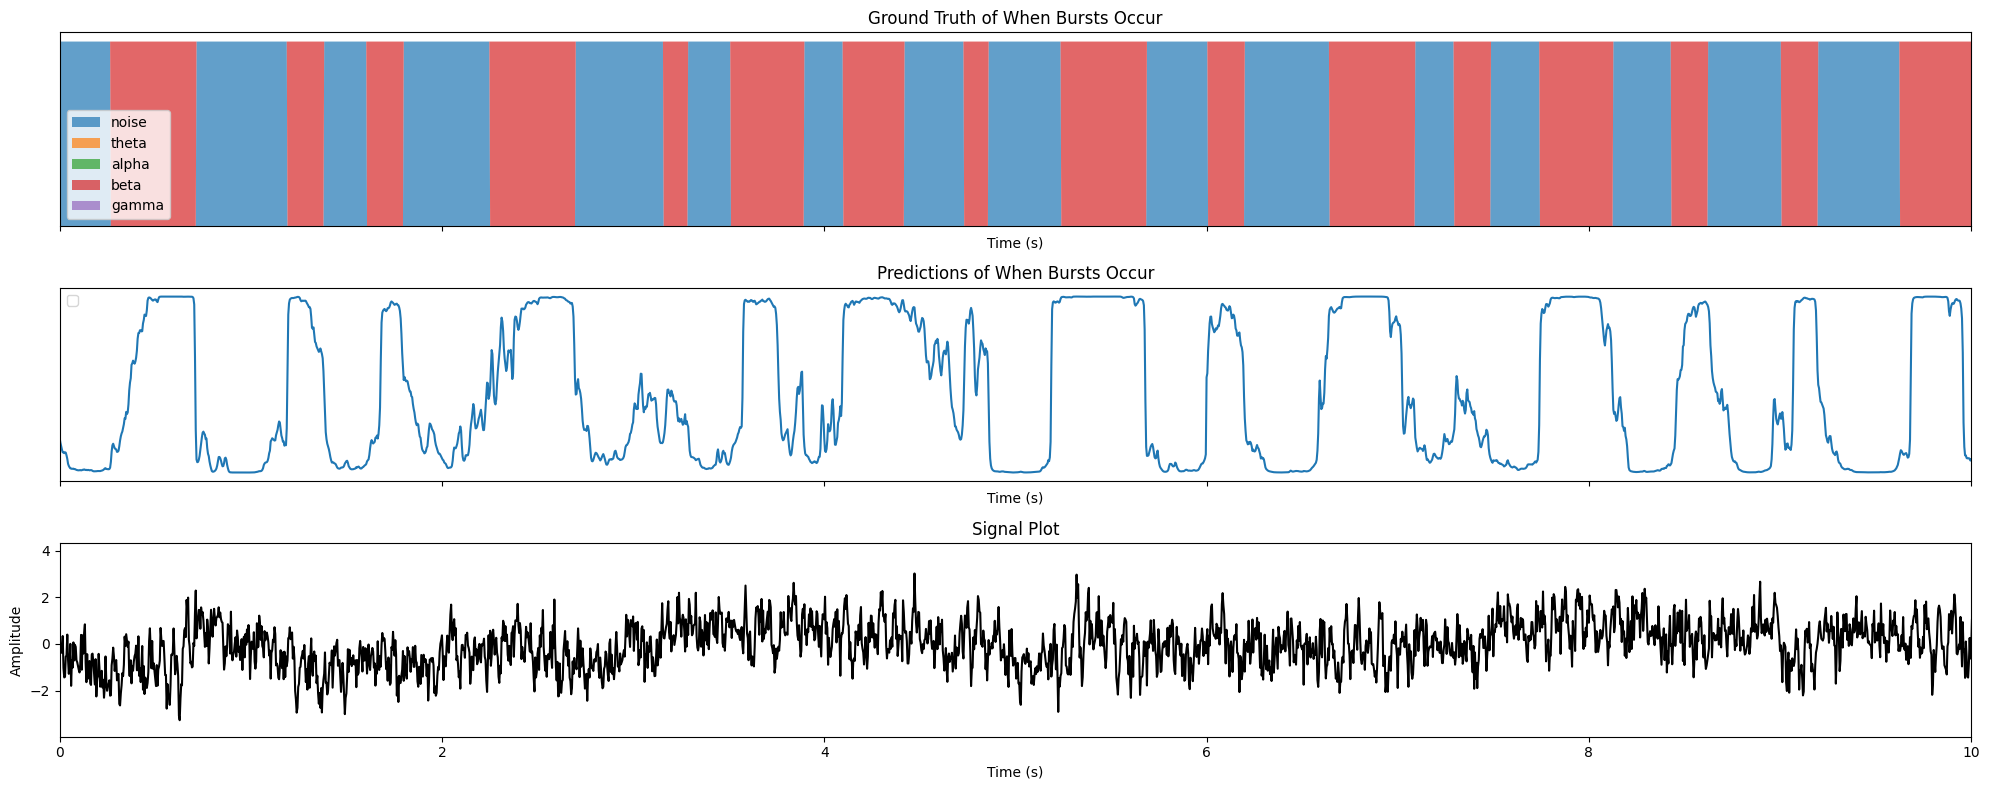

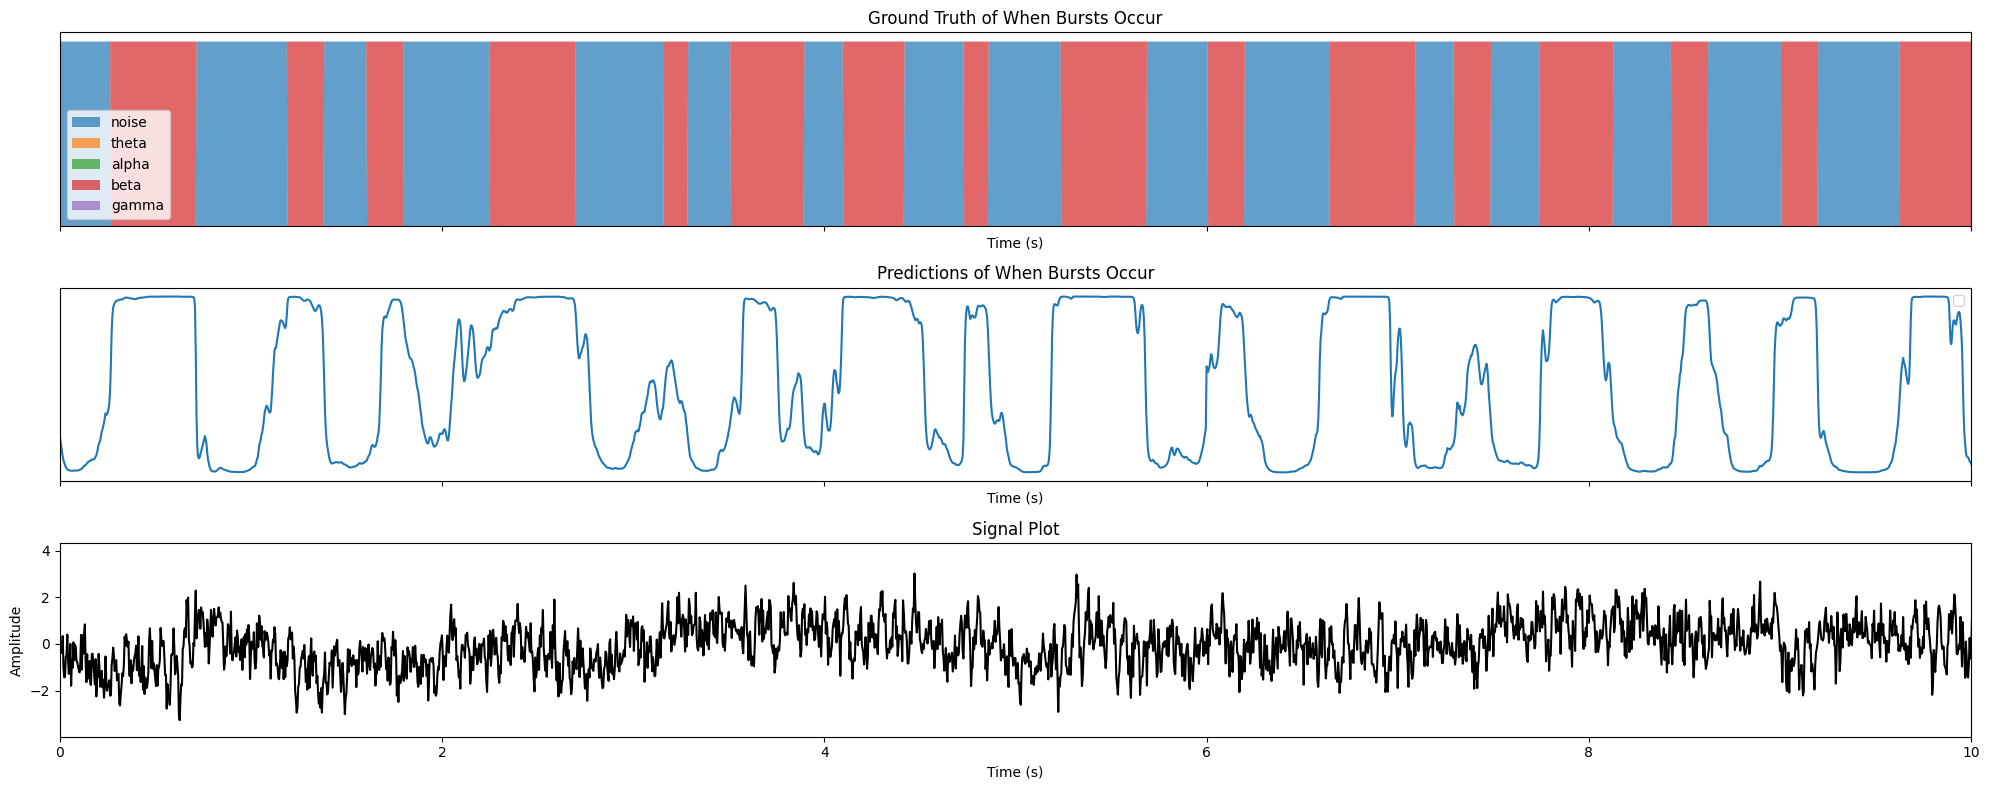

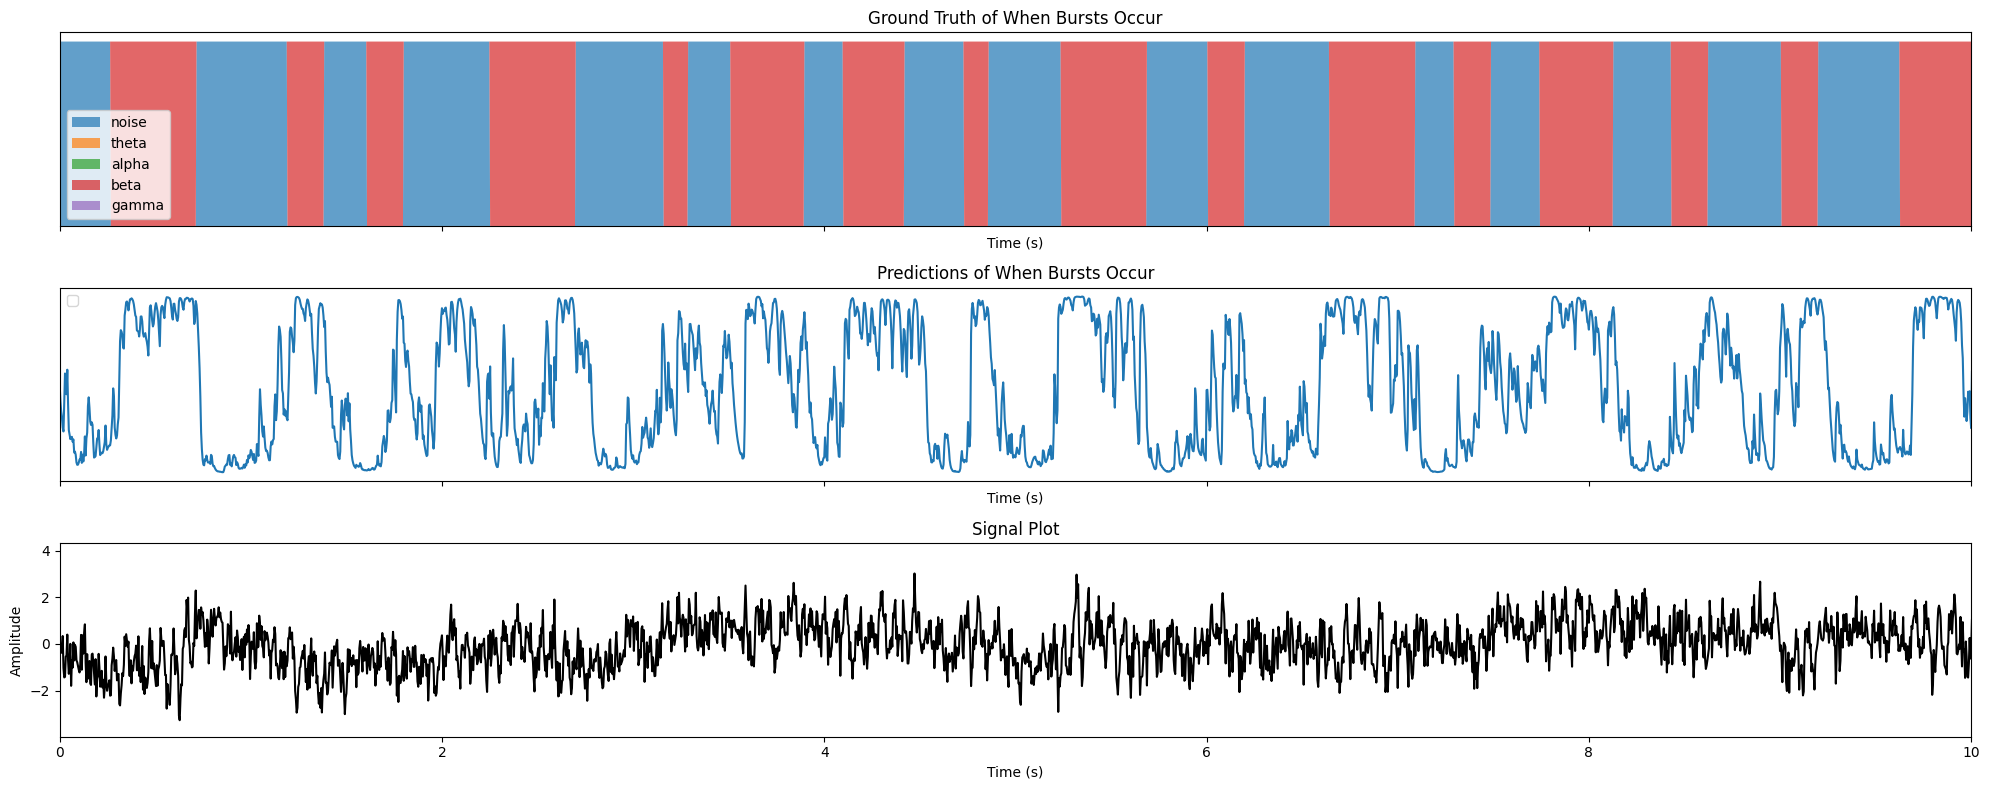

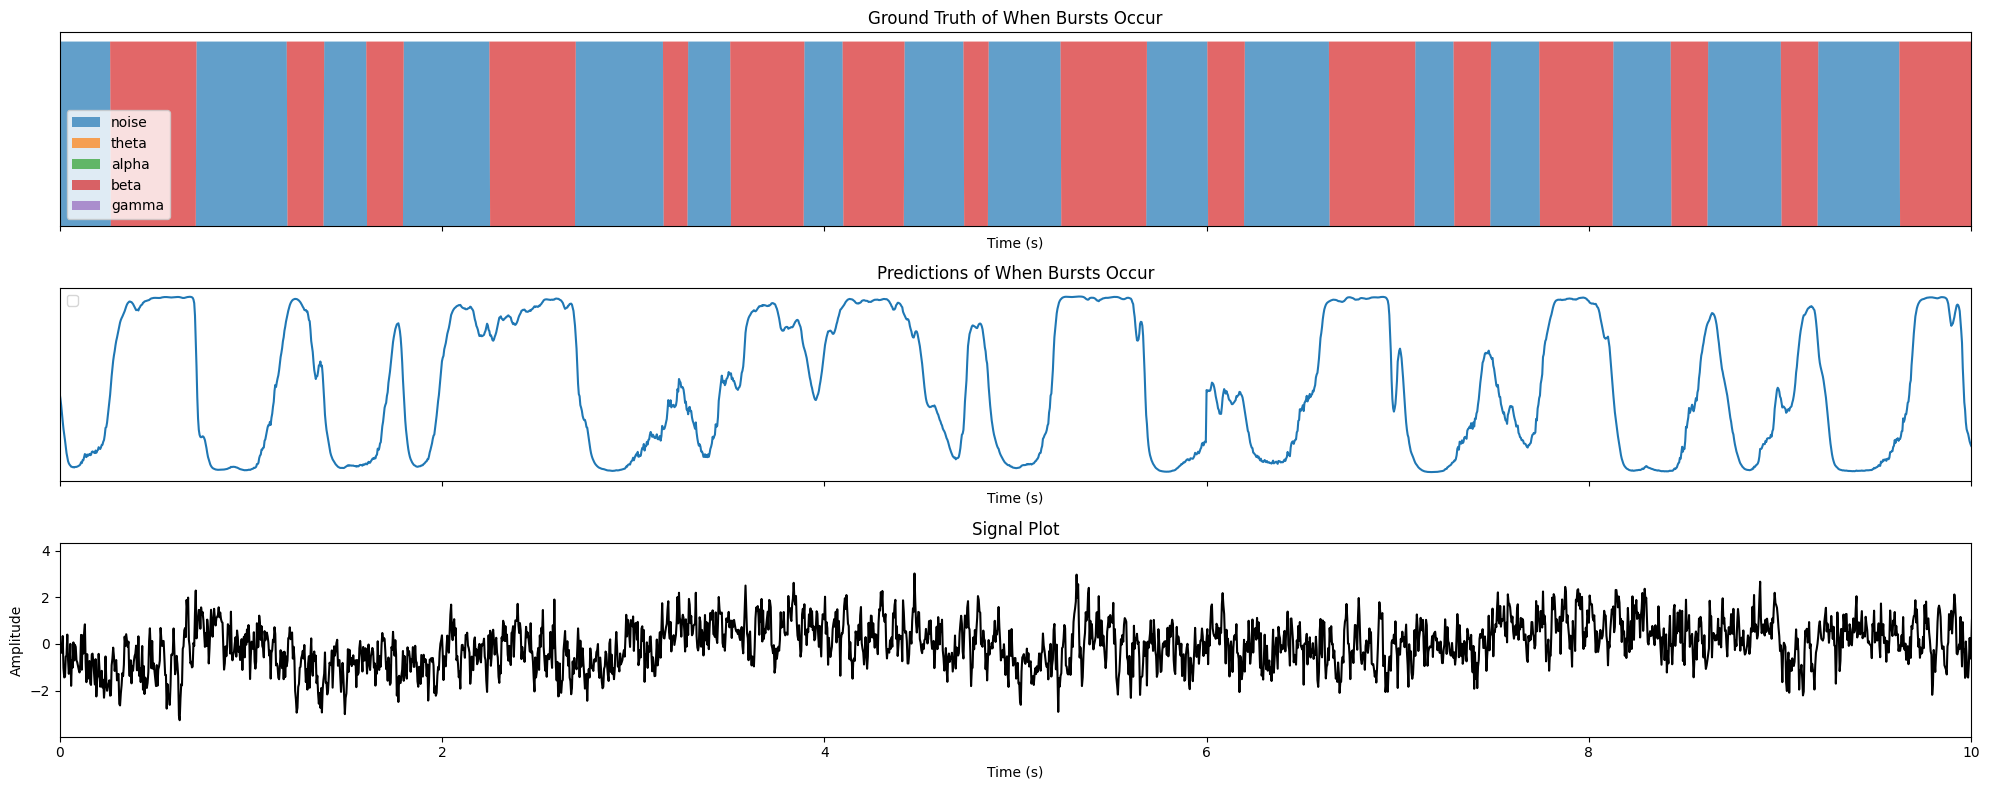

In [ ]:
sample = 0 # Only Sample available
freq = 11
noise = 0
num_features = 1

visualize_training_data(label_vec_trim[sample,freq,noise], data_vec_trim[sample,freq,noise, : , :num_features], reshaped_y_pred_signal[sample,freq,noise])
visualize_training_data(label_vec_trim[sample,freq,noise], data_vec_trim[sample,freq,noise, : , :num_features], reshaped_y_pred_allF[sample,freq,noise])

visualize_training_data(label_vec_trim[sample,freq,noise], data_vec_trim[sample,freq,noise, : , :num_features], reshaped_y_pred_signal_LSTM[sample,freq,noise])
visualize_training_data(label_vec_trim[sample,freq,noise], data_vec_trim[sample,freq,noise, : , :num_features], reshaped_y_pred_allF_LSTM[sample,freq,noise])


In [ ]:
def visualize_training_data(label_sample, signal_sample, pred_sample, sampling_frequency=250, duration=30, time_window=(0, 10), category_labels=['noise', 'theta', 'alpha', 'beta', 'gamma']):
    """
    Visualizes training data with ground truth labels and signal plot.

    Args:
        label_sample (np.ndarray): 1D array of ground truth labels.
        signal_sample (np.ndarray): 1D array of signal data.
        sampling_frequency (int, optional): Sampling frequency of the data. Defaults to 250.
        duration (int, optional): Duration of the data in seconds. Defaults to 60.
        time_window (tuple, optional): Time window to display in seconds (start, end). Defaults to (0, 10).
        category_labels (list, optional): Labels for the categories in the stackplot. Defaults to ['noise', 'beta'].
    """

    time_vec = np.linspace(0, duration, duration * sampling_frequency, endpoint=False)

    fig, ax = plt.subplots(3, 1, figsize=(20, 8), sharex=True)

    # Create a one-hot encoded matrix for stackplot
    label_sample = du.one_hot_encode_single_sample(label_sample, [0,1,2,3,4])  # Use unique labels for categories
    # pred_sample = du.one_hot_encode_single_sample(pred_sample, [0,1,2,3,4])  # Use unique labels for categories

    # Visualizing burst labels as colors
    ax[0].stackplot(time_vec, label_sample.T, labels=category_labels[:label_sample.shape[1]], alpha=0.7)  # Adjust labels based on categories
    ax[0].set_xlabel("Time (s)")
    ax[0].set_yticks([])  # y-axis does not mean anything
    ax[0].set_title("Ground Truth of When Bursts Occur")
    ax[0].legend()

        # Visualizing burst labels as colors
    ax[1].plot(time_vec, pred_sample)  # Adjust labels based on categories
    ax[1].set_xlabel("Time (s)")
    ax[1].set_yticks([])  # y-axis does not mean anything
    ax[1].set_title("Predictions of When Bursts Occur")
    ax[1].legend()

    # the period of blue: bursts
    ax[2].plot(time_vec, signal_sample, color="k")
    ax[2].set_xlabel("Time (s)")
    ax[2].set_ylabel("Amplitude")
    ax[2].set_title("Signal Plot")

    plt.xlim(time_window[0], time_window[1])
    plt.tight_layout()
    plt.show()

7500


(0.0, 10.0)

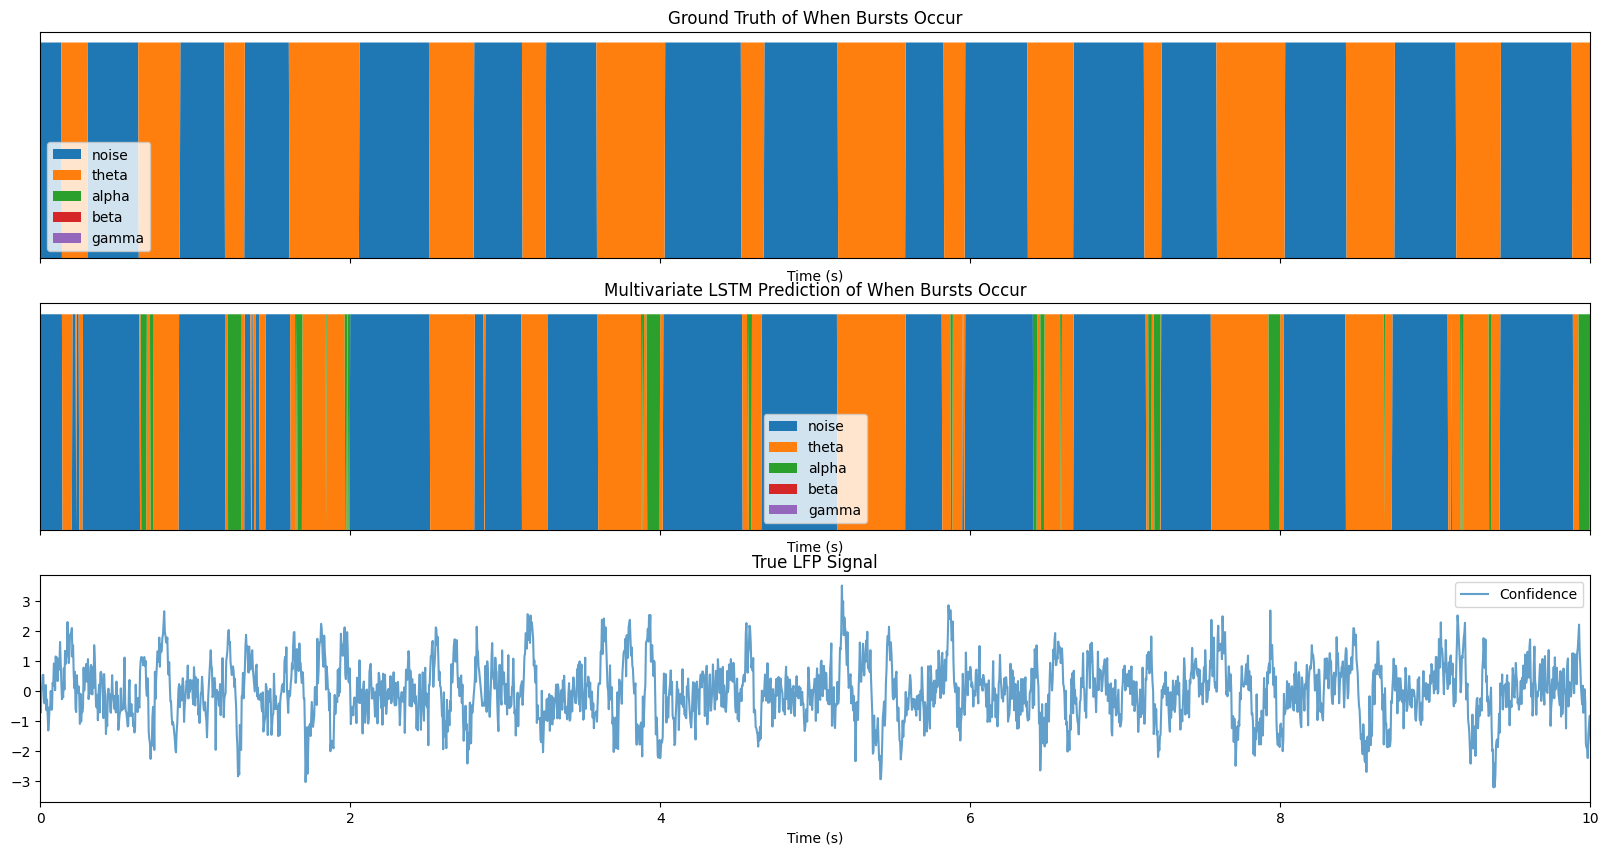

In [ ]:
time_vec = np.linspace(0, 30, 30 * 250, endpoint=False)

# Bad ones are 1, 7, 8
sample_number = 1
offset = sample_number * len(time_vec)
print(offset)
y_vis_real = y_test_multi.flatten()
y_vis_pred = y_pred_multi.flatten()


# Define class names
class_names = ['noise', 'theta', 'alpha', 'beta', 'gamma']

y_vis_real = du.one_hot_encode_single_sample(y_vis_real,).T
y_vis_pred = du.one_hot_encode_single_sample(y_vis_pred).T

# Define Raw Data
label_sample = y_test[sample_number].flatten()
signal_sample = [i[0] for i in X_test[sample_number]]
power_sample = [i[1] for i in X_test[sample_number]]
# Wavelet_sample = [i[2] for i in X_train[sample_number]]
# Wavelet_sample2 = [i[3] for i in X_train[sample_number]]
# H_amp_sample = [i[4] for i in X_train[sample_number]]


# Visualize the actual vs predicted labels
fig, ax = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

# visulizing burst labels as colors
ax[0].stackplot(time_vec, y_vis_real, labels=class_names)
ax[0].set_xlabel("Time (s)")
ax[0].set_yticks([]) #y-axis does not mean anything
ax[0].set_title("Ground Truth of When Bursts Occur")
ax[0].legend()
ax[0].set_xlim(0, 10)

# visulizing burst labels as colors
ax[1].stackplot(time_vec, y_vis_pred, labels=class_names)
ax[1].set_xlabel("Time (s)")
ax[1].set_yticks([]) #y-axis does not mean anything
ax[1].set_title("Multivariate LSTM Prediction of When Bursts Occur")
ax[1].legend()
ax[0].set_xlim(0, 10)

# visulizing burst confidence
ax[2].plot(time_vec, signal_sample, label='Confidence', alpha=0.7)
ax[2].set_xlabel("Time (s)")
ax[2].set_title("True LFP Signal")
ax[2].legend()
ax[0].set_xlim(0, 10)
